In [1]:
from datetime import datetime
import pickle

import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
CSV_PATH = r'C:\Users\guil\Downloads\MTA_Bus_Hourly_Ridership__Beginning_February_2022_20240121.csv'
df = pd.read_csv(CSV_PATH)

除去标题行：27740895 rows x 6 columns
- **transit_timestamp**: from *2022/2/1* to *2024/1/20*, *01:00AM* to *12:00PM*, 1 hour interval
- **bus_route**: B1 to B100, and more(Q1, Q2, ...)
- **payment_method**
- **fare_class_category**
- **ridership**
- **transfers**

需将12小时制时间转换为时间戳以排序

payment_method 和 fare_class_category 是我们不关心的特征，并且认为流量为 ridership 和 transfers 之和

将各个 bus_route 作为最终结果中的 node，最终每个时空节点的流量是各个 payment_method 和 fare_class_category 下的流量相加

处理需要30分钟左右：

In [4]:
time_slots_12 = df['transit_timestamp'].unique()
time_slot_map = {time: idx for idx, time in enumerate(time_slots_12)}
bus_routes = df['bus_route'].unique()
bus_route_map = {route: idx for idx, route in enumerate(bus_routes)}

data = np.zeros(shape=(len(time_slots_12), len(bus_routes)), dtype=np.int32)

for _, row in tqdm(df.iterrows(), total = len(df)):
    flow = row['ridership'] + row['transfers']
    time = row['transit_timestamp']
    time_idx = time_slot_map[time] 
    route = row['bus_route']
    route_idx = bus_route_map[route]
    data[time_idx][route_idx] = flow

result_df = pd.DataFrame(data, columns=bus_routes)

# Convert 12-hour to timestamp inorder to sort, then convert back to 24-hour
result_df.insert(0, 'time', time_slots_12)
timestamp = [pd.to_datetime(time, format='%m/%d/%Y %I:%M:%S %p').timestamp() for time in time_slots_12]
result_df['time'] = timestamp
result_df.sort_values(by=['time'], inplace=True)
time_slots_24 = [datetime.utcfromtimestamp(ts).strftime('%m/%d/%Y %H:%M:%S') for ts in timestamp]
result_df['time'] = time_slots_24

# Save data as CSV
result_df.to_csv('data.csv', index=False)
# Save data as pickle
DataFormat = {
    "TimeRange": ['2022-2-1', '2024-1-20'],    # 起止时间 str eg:['2016-10-01', '2016-11-30']
    "TimeFitness": 60,  # 时间粒度 int 单位为min
    "Node": {
        "TrafficNode": result_df.values[:, 1:],  # np.array, with shape [time_slots, num-of-node] eg:(1440,256) 
        "TrafficMonthlyInteraction": [], # np.array, With shape [month, num-of-node. num-of-node]
        "StationInfo": [],  # list of [id, build-time, lat, lng, name], eg:['0', 0, 34.210542575000005, 108.91390095, 'grid_0']
        "POI": []
    },
    "Grid": {
        "TrafficGrid": [], # with shape [slots, num-of-node. num-of-node] eg:(120, 256, 256)
        "GridLatLng": [],  # 对角线点的经纬度 eg:[[34.20829427, 108.91118]]
        "POI": []
    },
    "ExternalFeature": {
        "Weather": []
    }
}

with open('data.pkl', 'wb') as f:
    pickle.dump(DataFormat, f)

100%|██████████| 27740895/27740895 [29:23<00:00, 15734.63it/s]


data: [15618, 331]

In [5]:
print(data.shape)

print(result_df.head())
print(result_df.info())

(17040, 331)
                     time  B1  B100  B103  B11  B12  B13  B14  B15  B16  ...  \
6804  02/01/2022 13:00:00   4     1     8    3    6    7    2   31    1  ...   
6805  02/01/2022 14:00:00   2     0     4    1    2    1    1    9    0  ...   
7877  02/01/2022 15:00:00   2     0     4    0    4    0    1   13    0  ...   
6806  02/01/2022 16:00:00   1     0     0    0    3    0    1   13    0  ...   
6807  02/01/2022 17:00:00   4     0     0    7   11    3    1   54    0  ...   

      X27  X38  X63  X64  X68  X80  X81  H.R.L.  Q00  POLICE / SHUTTLE / BUSES  
6804    1    0    0    0    0    0    0       0    0                         0  
6805    0    0    0    0    0    0    0       0    0                         0  
7877    0    0    0    0    0    0    0       0    0                         0  
6806    0    0    0    0    0    0    0       0    0                         0  
6807    0    0    0    0    0    0    0       0    0                         0  

[5 rows x 332 colum

Visualize the distribution of the traffic data:

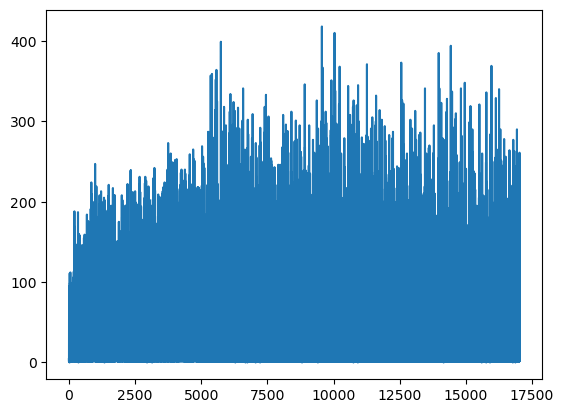

In [11]:
import matplotlib.pyplot as plt
plt.plot(DataFormat['Node']['TrafficNode'][:, 0])
plt.show()